**To Do:** 

1) Repair Time Distribution
2) Repair Counter -> Higher -> Spoil more often (Upgrade vs Repair)
3) ~~Resupply~~
4) Substitute weibull for conditional forest
5) ~~Wrappers - Monitor + Normalize~~
6) Max Resources and Duration
7) ~~Convert to Box~~
8) ~~Save vec_env~~
9) ~~Sampling~~
10) Demand
11) Fault Types
12) Backlog Cost
13) Real World Applications
14) Real Age

In [1]:
import pandas as pd
import numpy as np

def load_data(file_path, data, split):

    return pd.read_pickle(file_path + data + "_" + split + ".pkl")

def create_data(Type='PdM2', split='Train', save=True):

    """
        Custom dataset must include:
            age: time since last failure
            Failure: 1 = failed, 0 = did not fail
            ttf: time to next failure (For display purposes, would not be fed into the model)
            Date: must be sorted sequentially
        
        Splits: Train, Test, None
    """

    file_path = 'Gym-PM/gym_pm/data/' + Type + '.csv'
    df = pd.read_csv(file_path)

    if Type == 'PdM2':

        df['Failure'] = df.Failure_today.apply(lambda x: 0 if x == 'No' else 1)
        df.Date = pd.to_datetime(df.Date)

        cutoff = '2016-10'
        if split == 'Train':
            df = df[(df.Date > '2015-03') & (df.Date < cutoff)]
        elif split == 'Test':
            df = df[df.Date >= cutoff]
        elif split == 'All':
            df = df[df.Date > '2015-03']
        else:
            return "Invalid Split"

        df = df.sort_values('Date')
        df.drop(columns = ['Fail_tomorrow', 'Failure_today', 'Parameter1_Dir', 
                           'Parameter2_9am', 'Parameter2_3pm'], inplace = True)
        df.fillna(0, inplace = True)
        df.reset_index(drop = True, inplace = True)

        # ttf
        failure_time = df.groupby(['Location', 'Date']).Failure.first() 
        failure_time = failure_time[failure_time == 1].reset_index() # Collect failure dates
        failure_time = failure_time.groupby('Location').Date.apply(np.array)
        failure_time = failure_time.reset_index()

        failure_time.rename(columns = {"Date": "ttf"}, inplace = True)
        df = df.merge(failure_time, how = 'inner', on = 'Location')
        df['age'] = df.ttf

        df.ttf = df.apply(lambda x: x['ttf'][x['ttf'] >= x['Date']], axis = 1)
        df = df[df.ttf.str.len() > 0] # Drop empty lists
        df.ttf = df.apply(lambda x: (x['ttf'][0] - x['Date']).days, axis = 1) # Calculate TTF

        # age
        df.age = df.apply(lambda x: x['age'][x['age'] < x['Date']], axis = 1)
        df = df[df.age.str.len() > 0] # Drop empty lists
        df.age = df.apply(lambda x: (x['Date'] - x['age'][-1]).days, axis = 1) # Calculate Age
        df = df[~(df.age + df.ttf <= 10)]
        df.reset_index(drop = True, inplace = True)
        df.drop(columns = ['Date', 'Location'], inplace = True)

        # Save data as pickle
        if save:
            df.to_pickle(file_path.replace('.csv', '_' + split + '.pkl'))

    return df

df = create_data('PdM2', split='Train', save=True)
df

,Min_Temp,Max_Temp,Leakage,Evaporation,Electricity,Parameter1_Speed,Parameter3_9am,Parameter3_3pm,Parameter4_9am,Parameter4_3pm,Parameter5_9am,Parameter5_3pm,Parameter6_9am,Parameter6_3pm,Parameter7_9am,Parameter7_3pm,RISK_MM,Failure,ttf,age
0,12.7,33.6,0.0,0.0,0.0,37.0,2.0,15.0,78.0,28.0,1011.9,1007.9,0.0,0.0,16.6,31.9,0.0,0,19,1
1,16.6,26.8,0.0,0.0,0.0,43.0,24.0,22.0,57.0,31.0,1013.3,1014.2,3.0,0.0,18.7,25.7,0.0,0,18,2
2,13.2,27.3,0.0,0.0,0.0,28.0,13.0,11.0,52.0,31.0,1023.9,1021.8,0.0,0.0,15.8,26.1,0.0,0,17,3
3,10.8,30.7,0.0,0.0,0.0,50.0,6.0,15.0,61.0,30.0,1022.7,1017.7,0.0,1.0,16.4,29.0,0.0,0,16,4
4,16.4,31.9,0.0,0.0,0.0,46.0,9.0,20.0,61.0,35.0,1013.7,1008.6,5.0,7.0,22.0,30.0,0.4,0,15,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11123,9.2,21.5,0.0,3.6,7.9,26.0,9.0,13.0,75.0,50.0,1029.7,1027.2,7.0,5.0,13.3,19.5,0.0,0,4,12
11124,9.6,21.0,0.0,3.8,10.1,43.0,11.0,24.0,83.0,45.0,1029.7,1025.1,6.0,2.0,13.1,20.5,0.0,0,3,13
11125,13.1,23.3,0.0,5.4,8.3,56.0,26.0,30.0,56.0,45.0,1021.5,1016.3,2.0,5.0,19.3,22.3,0.6,0,2,14
11126,16.0,16.7,0.6,5.4,0.0,44.0,20.0,7.0,82.0,89.0,1009.7,1008.2,8.0,8.0,16.4,16.0,9.4,0,1,15


In [2]:
def update_boundaries(data='PdM2', save=True,
                      file_path='Gym-PM/gym_pm/data/'):

    obs_bound = pd.DataFrame()
    df = create_data(data, split='All', save=False)
    obs_bound['high'] = df.max()
    obs_bound['low'] = df.min()

    if save:
        obs_bound.to_pickle(file_path + data + '_Bound.pkl')

update_boundaries(data='PdM2', save=True)

Text(0, 0.5, 'Freq')

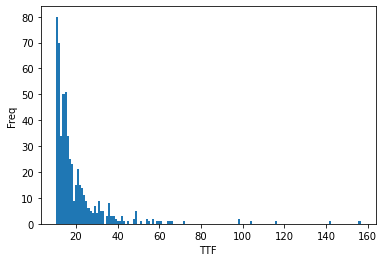

In [3]:
import matplotlib.pyplot as plt

# Minimum ttf = 11
# Should repair when age = 10. If we repair when age == ttf, 
# this is equivalent to repairing only when the machine fails.

ttf_dist = df[df.Failure == 1].age.value_counts().to_dict()
plt.bar(ttf_dist.keys(), ttf_dist.values(), width=1)
plt.xlabel('TTF')
plt.ylabel('Freq')

In [4]:
# Import Modules
import numpy as np

class Train_v2:

    def __init__(self, data, split, 
                 repair_cost, file_path):

        self.working = 1

        # Cost elements
        self.repair_cost = repair_cost

        self.repair_counter = 0
        self.repair_time = 0
        self.repair_status = 0

        # Data
        try:
            self.df = load_data(file_path, data, split)
        except:
            print('Data not found. Please run the create_data function.')

    # Deterioration
    def failure_check(self, time_step):

        # Break down
        if self.df.iloc[time_step].Failure:
            self.working = 0
            return
        
    def repair(self):

        self.repair_time = 1
        self.repair_counter += 1
        self.working = 1
        self.repair_status = 1

In [5]:
import gym
from gym import spaces
import time
import numpy as np
import pandas as pd
# from gym_pm.envs.Objects import Train_v2
from IPython.display import display, clear_output

class Railv2_Env(gym.Env):
    metadata = {"render.modes": ["console"]}

    def __init__(self, env_config=None, data='PdM2', 
                 split='Train', repair_cost=30,
                 file_path='Gym-PM/gym_pm/data/'):

        # Cost elements
        self.repair_cost = repair_cost

        # Initialize everything
        self.data = data
        self.split = split
        self.file_path = file_path
        self.reset()

        # Episode length
        self.max_duration = len(self.machine.df) # max time

        # action space
        self.action_space = spaces.Discrete(2)

        # obs space
        obs_bound = load_data(self.file_path, data, 'Bound')
        obs_bound = obs_bound.to_dict(orient='index')
        obs_bound.pop('ttf')

        obs_space = {}
        for i, j in obs_bound.items():
            if i == 'Failure':
                obs_space[i] = spaces.MultiBinary(1)
            else:
                obs_space[i] = spaces.Box(low=j['low'], high=j['high'], shape=(1,), dtype=np.float32)

        self.observation_space = spaces.Dict(obs_space)

    def reset(self):

        # reset timer
        self.timer = 0
        # reset time_step
        self.time_step = 0

        self.machine = Train_v2(data=self.data,
                                split=self.split,
                                repair_cost=self.repair_cost,
                                file_path=self.file_path)

        return self.observation()

    def observation(self):
        
        state = self.machine.df.iloc[self.time_step].to_dict()
        state.pop('ttf')
        state = {i: np.array([j], dtype='float32') for (i, j) in state.items()}

        return state

    def get_reward(self):

        reward = 0.
        if self.machine.repair_status == False:
            reward += 100
        # Repair Cost
        reward -= self.machine.repair_cost * self.machine.repair_status * self.machine.repair_time
        if self.machine.working == False:
            reward -= 200

        return reward

    def check_done(self):

        if self.timer >= self.max_duration:
            done = True
        else:
            done = False

        return done

    def step(self, action):

        # Reset Repair Status
        self.machine.repair_status = 0

        # Deterioriation
        self.machine.failure_check(self.time_step)

        # Interactions (Add more as desired)
        if action == 0:
            self.machine.repair()
            # Reset time_step
            self.time_step = np.random.choice(self.machine.df[self.machine.df.age == 1].index)
        else:
            pass

        obs = self.observation()
        reward = self.get_reward()
        done = self.check_done()
        info = {}

        self.timer += 1

        if (self.machine.working) and (self.machine.repair_status == 0):
            self.time_step += 1

        return obs, reward, done, info

    def render(self, mode='console'):

        result = self.machine.df.iloc[self.time_step][['age', 'ttf', 'Failure']]

        result.Failure = result.Failure.astype(bool)
        result['repair_count'] = self.machine.repair_counter
        result['reward'] = self.get_reward()
        result['time_step'] = int(self.time_step)
        result['duration'] = int(self.timer)
        result = result.to_frame('Results')
            
        if mode == 'human':

            clear_output(wait=True)
            display(result)
            time.sleep(1)

        return result

    def close(self):
        pass


# Test Environment

In [6]:
from stable_baselines3.common.env_checker import check_env

env = Railv2_Env()
check_env(env, warn=True)

AttributeError: module 'gym' has no attribute 'GoalEnv'

In [ ]:
env.reset()
for _ in range(5):
    env.render('human')
    env.step(env.action_space.sample()) # take a random action

    if env.check_done():
        break

,Results
age,2.0
ttf,11.0
Failure,False
repair_count,2
reward,100.0
time_step,2619
duration,4
